## MULTI DAPI VAE in PYRO

### IMPORT NECESSARY MODULES

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%%bash
#ls

In [3]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1" #for debugging, it decrease performance dramatically

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as mp

from LOW_LEVEL_UTILITIES.utilities import show_batch, save_obj, load_obj, dataset_in_memory, check_datasets
from LOW_LEVEL_UTILITIES.utilities import train_one_epoch, evaluate_one_epoch, test_model, linear_decay_p_factor
from simulation_dictionary import SimulationDictionary 
from VAE.vae_model import Compositional_VAE

import numpy as np
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO #,TraceEnum_ELBO, TraceGraph_ELBO, config_enumerate, JitTraceEnum_ELBO 
from pyro.optim import Adam, Adamax, SGD

# Set up pyro environment
pyro.clear_param_store()
pyro.set_rng_seed(0)

# Get the data

In [5]:
#disk_data_dir = "/home/ldalessi/DATA/MULTI_DISK/"
#real_data_dir = "/home/ldalessi/DATA/DAPI_ONLY_v3/"

#batch_size = 4
#write_dir  = '/Users/ldalessi/DAPI_unsupervised/spacetx-research/ARCHIVE/' # local machine
#mMNIST_data_dir = "/Users/ldalessi/DAPI_unsupervised/DATA/MULTI_MNIST/" #local machine
#train_dataset = dataset_in_memory(mMNIST_data_dir,"multi_mnist_train_no_bg",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(mMNIST_data_dir,"multi_mnist_test_no_bg",use_cuda=torch.cuda.is_available())

batch_size = 256
write_dir  = '/home/jupyter/REPOS/spacetx-research/ARCHIVE/' # V4
mMNIST_data_dir = "/home/jupyter/REPOS/spacetx-research/DATA/MULTI_MNIST/"  #V4
train_dataset = dataset_in_memory(mMNIST_data_dir,"multi_mnist_train_large",use_cuda=torch.cuda.is_available())
test_dataset  = dataset_in_memory(mMNIST_data_dir,"multi_mnist_test_large",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(disk_data_dir,"multi_disk_train_v1",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(disk_data_dir,"multi_disk_test_v1",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(disk_data_dir,"multi_disk_train_no_bg",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(disk_data_dir,"multi_disk_test_no_bg",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(real_data_dir,"DAPI_dataset_train",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(real_data_dir,"DAPI_dataset_test",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(mMNIST_data_dir,"multi_mnist_train_large",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(mMNIST_data_dir,"multi_mnist_test_large",use_cuda=torch.cuda.is_available())



Dataset lenght: 60000
imgs.shape torch.Size([8, 1, 80, 80])
type(imgs) <class 'torch.Tensor'>
imgs.device cuda:0
torch.max(imgs) tensor(1., device='cuda:0')
torch.min(imgs) tensor(0., device='cuda:0')


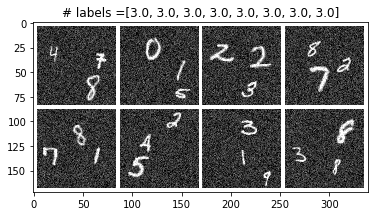

In [6]:
check_datasets(train_dataset)

Dataset lenght: 1000
imgs.shape torch.Size([8, 1, 80, 80])
type(imgs) <class 'torch.Tensor'>
imgs.device cuda:0
torch.max(imgs) tensor(1., device='cuda:0')
torch.min(imgs) tensor(0., device='cuda:0')


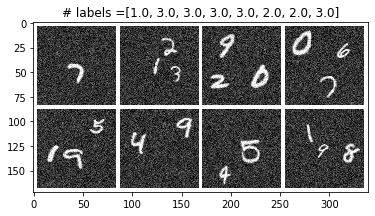

In [7]:
check_datasets(test_dataset)

In [8]:
#size=15
#r = test_dataset.analyze_brightness_distribution(size=size,stride=3)
#a = plt.hist(r.view(-1), bins=100, range=(0,1),density=True)
#plt.title("Empirical PDF")
#plt.xlabel("Average intensity in box of size "+str(size))

In [9]:
#size=35
#r = test_dataset.analyze_brightness_distribution(size=size,stride=3)
#a = plt.hist(r.view(-1), bins=100, range=(0,1),density=True)
#plt.title("Empirical PDF")
#plt.xlabel("Average intensity in box of size "+str(size))

In [10]:
#imgs_in, labels = train_dataset.load(128)
#print(labels[0])
#show_batch(imgs_in[:1])

In [11]:
#b = plt.hist(imgs_in.view(-1).cpu().numpy(), bins=100, range=(0,1),density=True)
#plt.title("Empirical PDF")
#plt.xlabel("pixel intensity")

# Generate the names

In [12]:
descriptor        = "25_to_current_v3_b" 
#descriptor        = "DISK_v4"
#descriptor        = "DISK_speed"
name_vae          = descriptor+"_vae"
name_history      = descriptor+"_hystory"
name_hyper_params = descriptor+"_hyper_params"
epoch_restart     = 44 
from_scratch = False


if(from_scratch):
    epoch_restart     = -1
    hyper_params=SimulationDictionary()
    hyper_params.check_consistency()
    print(hyper_params)
    
    min_loss = 99999999
    history_dict = {
        "train_loss" : [],
        "test_loss" : [],
        "fg_mu" : [],
        "bg_mu" : [],
        "fg_sigma" : [],
        "bg_sigma" : [],
        "normal_sigma" : [],
        "std_bx" : [],
        "std_by" : [],
        "std_bw" : [],
        "std_bh" : []
        }
    
    vae = Compositional_VAE(hyper_params)
    vae.reset()
    
else:
    hyper_params = load_obj(write_dir,name_hyper_params+"_"+str(epoch_restart))
    #hyper_params['REGULARIZATION.p_corr_factor']=0.5
    #hyper_params['REGULARIZATION.lambda_small_box_size']=0.0
    #hyper_params['REGULARIZATION.lambda_big_mask_volume']=1.0
    #hyper_params['REGULARIZATION.lambda_tot_var_mask']=0.0
    #hyper_params['REGULARIZATION.lambda_overlap']=0.0
    #hyper_params['REGULARIZATION.LOSS_ZMASK']=1.0
    #hyper_params['REGULARIZATION.LOSS_ZWHAT']=10.0
    hyper_params.check_consistency()
    print(hyper_params)
    
    history_dict = load_obj(write_dir,name_history+"_"+str(epoch_restart))
    min_loss = min(history_dict["test_loss"])
    
    vae = Compositional_VAE.load(hyper_params,write_dir,name_vae+"_"+str(epoch_restart))

save_obj(hyper_params,write_dir,name_hyper_params+"_write_test")

{'SD.width': 28, 'SD.dim_h1': -1, 'SD.dim_h2': -1, 'ZWHAT.dim': 50, 'ZMASK.dim': 50, 'REGULARIZATION.prob_corr_factor': 0.0, 'REGULARIZATION.lambda_small_box_size': 0.0, 'REGULARIZATION.lambda_big_mask_volume': 1.0, 'REGULARIZATION.lambda_tot_var_mask': 0.0, 'REGULARIZATION.lambda_overlap': 0.0, 'REGULARIZATION.LOSS_ZMASK': 1.0, 'REGULARIZATION.LOSS_ZWHAT': 10.0, 'PRIOR.n_objects_max': 6, 'PRIOR.min_object_size': 15, 'PRIOR.max_object_size': 35, 'PRIOR.expected_object_size': 20, 'IMG.size_raw_image': 80, 'IMG.ch_in_description': ['DAPI'], 'UNET.N_max_pool': 4, 'UNET.N_up_conv': 2, 'UNET.CH_after_first_two_conv': 32, 'UNET.N_prediction_maps': 1, 'NMS.score_threshold': -1, 'NMS.overlap_threshold': 0.2, 'use_cuda': True}


In [13]:
#putative_imgs,putative_masks,background,c = vae.model()
#print("putative_imgs.shape",putative_imgs.shape)
#print("putative_masks.shape",putative_masks.shape)
#print("background.shape",background.shape)
#print("c.shape",c.shape)
#print("max(putative_imgs)",torch.max(putative_imgs))

In [14]:
#show_batch(background)

In [15]:
#show_batch(putative_imgs[0])

In [16]:
#show_batch(putative_masks[0])
#print(torch.min(putative_masks),torch.max(putative_masks))

In [17]:
#imgs_prior = vae.generate_synthetic_data(N=2)
#show_batch(imgs_prior[:8,:1,:,:])
#print("imgs_prior.shape",imgs_prior.shape)
#print("type(imgs_prior)",type(imgs_prior))
#print("imgs_prior.device",imgs_prior.device)
#print("torch.max(imgs_prior)",torch.max(imgs_prior))
#print("torch.min(imgs_prior)",torch.min(imgs_prior))

In [18]:
#putative_imgs,putative_masks,background,c = vae.model(imgs_prior.cuda())
##putative_imgs,pixel_weights,background,c = vae.model(imgs_prior)
#
#print("putative_imgs.shape",putative_imgs.shape)
#print("putative_masks.shape",putative_masks.shape)
#print("background.shape",background.shape)
#print("c.shape",c.shape)

In [19]:
#rec_img,z_where,putative_imgs,putative_masks,logp,reg = vae.reconstruct_img(imgs_prior,True)
#
#print("rec_img.shape",rec_img.shape)
#print("min, max of rec_img)",torch.min(rec_img),torch.max(rec_img))
#print("putative_imgs.shape",putative_imgs.shape)
#print("putative_masks.shape",putative_masks.shape)
#print("logp.logp_off.shape",logp.logp_off.shape)
#print("logp.logp_on_cauchy.shape",logp.logp_on_cauchy.shape)
#print("logp.logp_on_normal.shape",logp.logp_on_normal.shape)
#print("reg.small_box_size.shape",reg.small_box_size.shape)
#print("reg.big_mask_volume.shape",reg.big_mask_volume.shape)
#print("reg.tot_var_mask.shape",reg.tot_var_mask.shape)
#print("reg.overlap_mask.shape",reg.overlap_mask.shape)
#show_batch(rec_img[:8,:,:,:])

### Debug model and guide

In [20]:
#print("TEST SAMPLE")
#test_model(vae.model, 
#           vae.guide, TraceGraph_ELBO())
#
#print("TEST PARALLEL ENUM")
#test_model(vae.model, 
#           config_enumerate(vae.guide, "parallel"), 
#           TraceEnum_ELBO(max_plate_nesting=2))

## Global parameters

In [13]:
TEST_FREQUENCY = 1
WRITE_FREQUENCY = 1
smoke_test= False
if(smoke_test):
    pyro.enable_validation(False)
    pyro.distributions.enable_validation(True)
    NUM_EPOCHS = 6 
else:
    pyro.enable_validation(False)
    pyro.distributions.enable_validation(False)
    NUM_EPOCHS = 101
    
# batch size
decay_lenght_scale = 25 

# setup the optimizer
#optimizer = Adamax(adam_args)
adam_args = {"lr": 1.0e-3} # pyro.tutorail has 1E-4 with Adam. I have used Adamax and 1E-3 for a while
optimizer = Adam(adam_args)

#svi = SVI(vae.model, config_enumerate(vae.guide, "parallel"), optimizer, loss=TraceEnum_ELBO(max_plate_nesting=2))
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO(max_plate_nesting=2))



# Actual train loop

In [23]:
# training loop




for delta_epoch in range(1,NUM_EPOCHS+1):
    epoch = delta_epoch+epoch_restart
    vae.train()   
    
    vae.overlap_threshold=hyper_params["NMS.overlap_threshold"]
    vae.randomize_nms_factor= 0.0
    vae.n_objects_max=hyper_params["PRIOR.n_objects_max"]
    vae.prob_corr_factor=linear_decay_p_factor(epoch,decay_lenght_scale)
    
    print("epoch,vae.prob_corr_factor",epoch,vae.prob_corr_factor)
    loss = train_one_epoch(svi, train_dataset, epoch, batch_size, verbose=(delta_epoch==1))
    print("[epoch %03d] train loss: %.4f" % (epoch, loss))
                
    history_dict["train_loss"].append(loss)
    try:
        history_dict["fg_mu"].append(pyro.param("fg_mu").item())
        history_dict["bg_mu"].append(pyro.param("bg_mu").item())
        history_dict["fg_sigma"].append(pyro.param("fg_sigma").item())
        history_dict["bg_sigma"].append(pyro.param("bg_sigma").item())
        history_dict["normal_sigma"].append(pyro.param("normal_sigma").item())
        history_dict["std_bx"].append(pyro.param("std_bx").item())
        history_dict["std_by"].append(pyro.param("std_by").item())
        history_dict["std_bw"].append(pyro.param("std_bw").item())
        history_dict["std_bh"].append(pyro.param("std_bh").item())
    except:
        pass
            
    if(epoch % TEST_FREQUENCY == 0):
        vae.eval()
        loss = evaluate_one_epoch(svi, test_dataset, epoch, batch_size, verbose=(delta_epoch==1))        
        history_dict["test_loss"].append(loss)
            
        if(loss < min_loss):
            min_loss = loss
            print("[epoch %03d] test  loss: %.4f --New Record--" % (epoch, loss)) 
        else:
            print("[epoch %03d] test  loss: %.4f " % (epoch, loss))
                
        if((loss == min_loss) or ((epoch % WRITE_FREQUENCY) == 0)):   
            # Save on disk
            vae.save_everything(write_dir,name_vae+"_"+str(epoch))
            save_obj(history_dict,write_dir,name_history+"_"+str(epoch))
            save_obj(hyper_params,write_dir,name_hyper_params+"_"+str(epoch))

epoch,vae.prob_corr_factor 0 0.5
i=   0 train_loss=-210766.85938
i=   1 train_loss=-210680.70312
i=   2 train_loss=-209381.42188
i=   3 train_loss=-207454.14062
i=   4 train_loss=-208892.00000


KeyboardInterrupt: 

# Check the results

In [14]:
print(history_dict["train_loss"][-5:])
print(history_dict["test_loss"][-5:])
print(history_dict["bg_mu"][-5:])
print(history_dict["fg_mu"][-5:])
print(history_dict["bg_sigma"][-5:])
print(history_dict["fg_sigma"][-5:])
print(history_dict["normal_sigma"][-5:])
print(history_dict["std_bx"][-5:])
print(history_dict["std_by"][-5:])
print(history_dict["std_bw"][-5:])
print(history_dict["std_bh"][-5:])

[-57766.16479700855, -57893.14833733974, -57773.68983707265, -57791.26111778846, -57934.021784855766]
[-57859.631510416664, -57745.33984375, -57728.0078125, -57517.119791666664, -57742.38671875]
[0.19063541293144226, 0.19059932231903076, 0.1907612532377243, 0.19075177609920502, 0.19067884981632233]
[0.9993698000907898, 0.9994290471076965, 0.9994827508926392, 0.9995313882827759, 0.9995755553245544]
[0.08021356910467148, 0.08026330918073654, 0.08026070892810822, 0.0802110880613327, 0.08025211840867996]
[0.24969317018985748, 0.2497219443321228, 0.2497481107711792, 0.2497716248035431, 0.24979329109191895]
[0.11423799395561218, 0.11464092135429382, 0.11553894728422165, 0.11563598364591599, 0.11239331215620041]
[0.10395319759845734, 0.10359767079353333, 0.10328405350446701, 0.10299094766378403, 0.10271556675434113]
[0.104015052318573, 0.10365112125873566, 0.10333113372325897, 0.10303478688001633, 0.10275771468877792]
[0.10656342655420303, 0.10605456680059433, 0.10555955022573471, 0.105078719

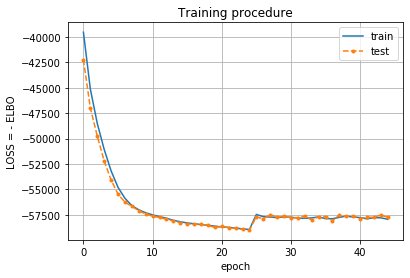

In [15]:
#plt.yscale('log')
y_shift=0
x_shift=0
plt.plot(np.arange(x_shift, x_shift+len(history_dict["train_loss"])), np.array(history_dict["train_loss"])+y_shift)
plt.plot(np.arange(x_shift, x_shift+len(history_dict["train_loss"]), TEST_FREQUENCY), np.array(history_dict["test_loss"])+y_shift, '.--')
plt.xlabel('epoch')
plt.ylabel('LOSS = - ELBO')
plt.title('Training procedure')
#plt.ylim(ymin = -10000, ymax=-4000)
plt.grid(True)
plt.legend(['train', 'test'])
#plt.show()
from matplotlib import pyplot as plt
plt.savefig(write_dir+name_vae+'_train.png')

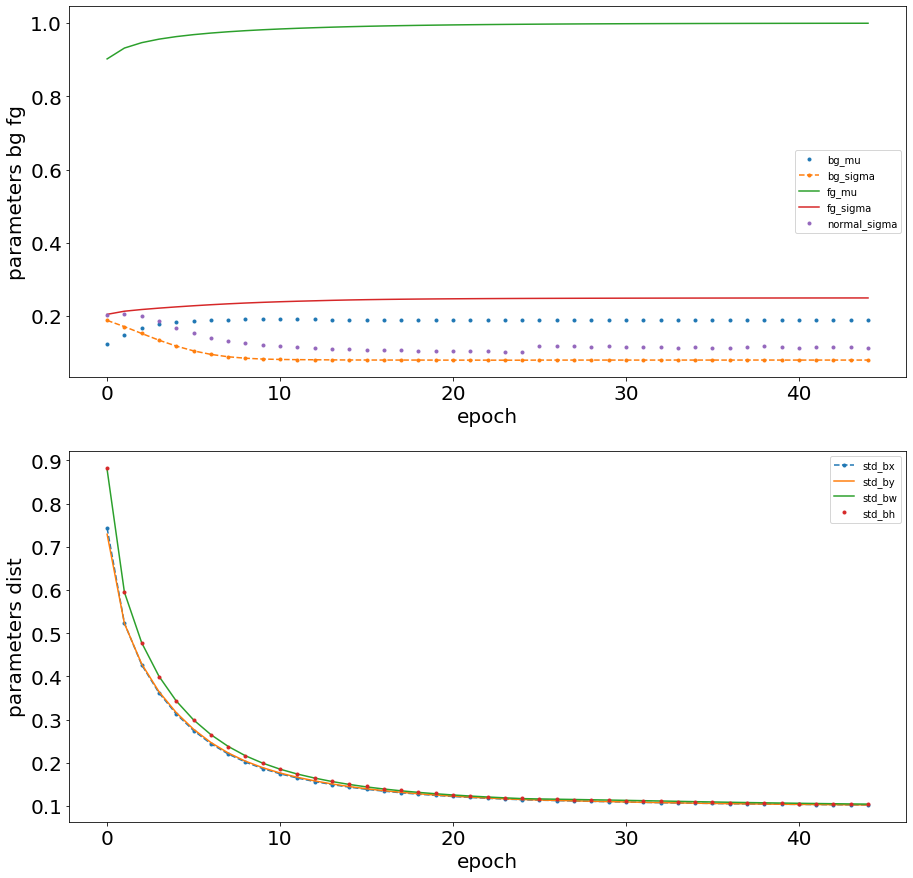

In [16]:
# Create a plot with the priors
fontsize=20
labelsize=20
fig, axs = plt.subplots(2,1, figsize=(15,15))
        
axs[0].set_xlabel('epoch',fontsize=fontsize)
axs[0].set_ylabel('parameters bg fg',fontsize=fontsize)
axs[0].tick_params(axis='both', which='major', labelsize=labelsize)
axs[0].plot(history_dict["bg_mu"],'.')
axs[0].plot(history_dict["bg_sigma"],'.--')
axs[0].plot(history_dict["fg_mu"],'-')
axs[0].plot(history_dict["fg_sigma"],'-')
axs[0].plot(history_dict["normal_sigma"],'.')
axs[0].legend(['bg_mu','bg_sigma','fg_mu','fg_sigma','normal_sigma'])
        
axs[1].set_xlabel('epoch',fontsize=fontsize)
axs[1].set_ylabel('parameters dist',fontsize=fontsize)
axs[1].tick_params(axis='both', which='major', labelsize=labelsize)
axs[1].plot(history_dict["std_bx"],'.--')
axs[1].plot(history_dict["std_by"],'-')
axs[1].plot(history_dict["std_bw"],'-')
axs[1].plot(history_dict["std_bh"],'.')
axs[1].legend(['std_bx','std_by','std_bw', 'std_bh'])
              
fig.savefig(write_dir+name_vae+'_hystory.png')

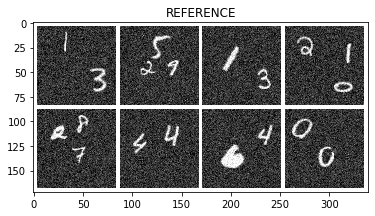

In [17]:
from matplotlib import pyplot as mp

#reference_dir = '/home/ldalessi/DATA/REFERENCE/'
reference_dir = '/home/jupyter/REPOS/spacetx-research/DATA/REFERENCES/'
name='reference_mMNIST_v2'
#name='reference_disks_v3'
#name='reference_dapi'

# create image if necessary
reference_imgs, labels=test_dataset.load(8)
save_obj(reference_imgs ,reference_dir,name)

reference_imgs = load_obj(reference_dir,name)
show_batch(reference_imgs[:8],nrow=4,npadding=4,title="REFERENCE")
mp.savefig(write_dir+name+'.png')

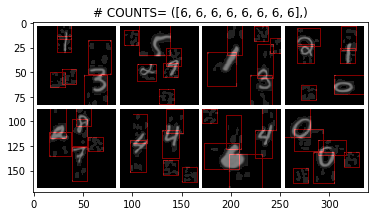

In [18]:
#vae.p_corr_factor = 0.0
rec_img,inference,putative_imgs,putative_masks,logp,reg,total_reg = vae.reconstruct_img(reference_imgs,True)
counts = torch.sum(inference.prob>0.5,dim=0).view(-1).cpu().numpy().tolist(),
b=show_batch(rec_img[:8],nrow=4,npadding=4,title="# COUNTS= "+str(counts))
mp.savefig(write_dir+name_vae+'_rec_both.png')

In [19]:
chosen=0
inference.prob[:,chosen].view(-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999], device='cuda:0')

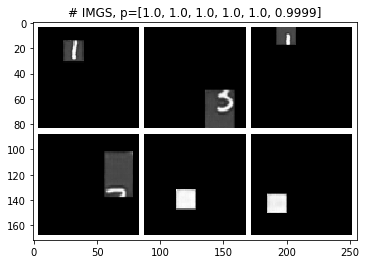

In [20]:
prob_tmp = np.round(inference.prob[:,chosen].view(-1).cpu().numpy(),decimals=4)*10000
prob_title = (prob_tmp.astype(int)/10000).tolist()
b=show_batch(putative_imgs[:,chosen],nrow=3,npadding=4,title="# IMGS, p="+str(prob_title))
mp.savefig(write_dir+name_vae+'_rec_imgs.png')

25_to_current_v3_b_vae


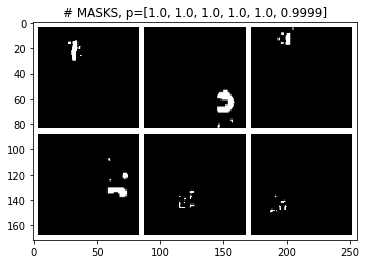

In [21]:
b=show_batch(putative_masks[:,chosen],nrow=3,npadding=4,title="# MASKS, p="+str(prob_title))
print(name_vae)
mp.savefig(write_dir+name_vae+'_rec_masks.png')

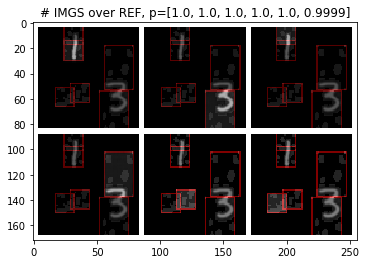

In [22]:
b = show_batch(rec_img[chosen]+putative_imgs[:,chosen], nrow=3, npadding=4,title="# IMGS over REF, p="+str(prob_title))

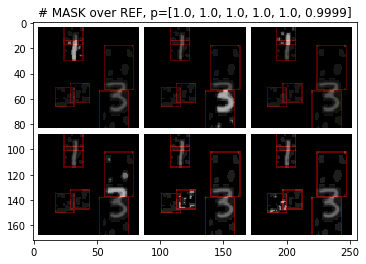

In [23]:
b = show_batch(rec_img[chosen]+putative_masks[:,chosen], nrow=3, npadding=4,title="# MASK over REF, p="+str(prob_title))

In [24]:
print("logp_off -------->",logp.logp_off[:,chosen].detach().cpu())
print("logp_on_cauchy -->",logp.logp_on_cauchy[:,chosen].detach().cpu())
print("logp_on_normal -->",logp.logp_on_normal[:,chosen].detach().cpu())
print("total_reg ------->",total_reg[:,chosen].detach().cpu())
print("probability object",inference.prob[:,chosen].detach().cpu().view(-1))

logp_off --------> tensor([4461.0381,  -74.3773,   25.1078,   55.4667,   80.1263,   83.1916])
logp_on_cauchy --> tensor([4562.9463,  115.7441,   47.9917,  118.1471,   38.7462,   48.8968])
logp_on_normal --> tensor([4625.3789,  289.6773,   83.3428,  247.3270,  100.2664,   99.1192])
total_reg -------> tensor([6.0928e-04, 4.6995e-03, 7.9528e-01, 1.4659e-01, 1.3370e-01, 6.0967e-01])
probability object tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999])


In [25]:
#print(reg)
for f in reg._fields:
    print(f,"-->",getattr(reg,f)[:,chosen].detach().cpu().view(-1))

small_box_size --> tensor([9.8468e-03, 6.7894e+00, 4.5578e-02, 5.9327e+00, 5.7986e-08, 2.7138e-07])
big_mask_volume --> tensor([6.0928e-04, 4.6995e-03, 7.9528e-01, 1.4659e-01, 1.3370e-01, 6.0967e-01])
tot_var_mask --> tensor([ 59.5253, 100.5600,  41.3575,  81.7312,  72.0996,  54.3507])
overlap_mask --> tensor([7.0536e+01, 8.4587e-02, 1.2640e+01, 1.5817e-02, 4.2869e+00, 5.6608e-01])


Text(0.5, 0, 'Log prob')

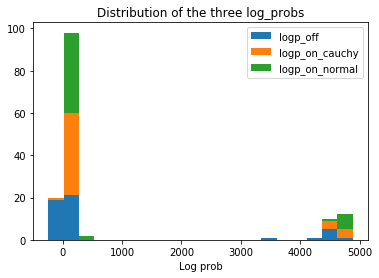

In [26]:
off=logp.logp_off.view(-1).detach().cpu().numpy()
on_c=logp.logp_on_cauchy.view(-1).detach().cpu().numpy()
on_n=logp.logp_on_normal.view(-1).detach().cpu().numpy()
a1 = plt.hist([off,on_c,on_n],bins=20,histtype="bar",stacked=True)
plt.legend(["logp_off","logp_on_cauchy","logp_on_normal"], loc='upper right')
plt.title("Distribution of the three log_probs")
plt.xlabel("Log prob")

# MAKE MOVIE

In [30]:
#rec_img,z_where,putative_imgs,putative_masks,logp,reg,total_reg = vae.reconstruct_img(reference_imgs,True)

_0000 0.5
_0001 0.48
_0002 0.46
_0003 0.44
_0004 0.42
_0005 0.4
_0006 0.38
_0007 0.36
_0008 0.33999999999999997
_0009 0.32
_0010 0.3
_0011 0.28
_0012 0.26
_0013 0.24
_0014 0.21999999999999997
_0015 0.2
_0016 0.18
_0017 0.15999999999999998
_0018 0.14
_0019 0.12
_0020 0.09999999999999998
_0021 0.08000000000000002
_0022 0.06
_0023 0.03999999999999998
_0024 0.020000000000000018
_0025 0.0
_0026 0.0
_0027 0.0
_0028 0.0
_0029 0.0
_0030 0.0
_0031 0.0
_0032 0.0
_0033 0.0
_0034 0.0
_0035 0.0
_0036 0.0
_0037 0.0
_0038 0.0
_0039 0.0
_0040 0.0
_0041 0.0
_0042 0.0
_0043 0.0
_0044 0.0
['25_to_current_v3_b_vae_0000.png', '25_to_current_v3_b_vae_0001.png', '25_to_current_v3_b_vae_0002.png', '25_to_current_v3_b_vae_0003.png', '25_to_current_v3_b_vae_0004.png', '25_to_current_v3_b_vae_0005.png', '25_to_current_v3_b_vae_0006.png', '25_to_current_v3_b_vae_0007.png', '25_to_current_v3_b_vae_0008.png', '25_to_current_v3_b_vae_0009.png', '25_to_current_v3_b_vae_0010.png', '25_to_current_v3_b_vae_0011.png', '2

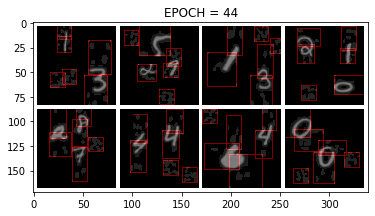

In [42]:
list_of_movie_files = []
for epoch in range(0,60,1):
    if(epoch<10):
        label ="_000"+str(epoch)
    elif(epoch<100):
        label = "_00"+str(epoch)
    elif(epoch<1000):
        label = "_0"+str(epoch)
    else:
        label = str(epoch)
    
    vae.prob_corr_factor = linear_decay_p_factor(epoch,decay_lenght_scale)

    try:
        vae.load_everything(write_dir,name_vae+"_"+str(epoch))
        print(label,vae.prob_corr_factor)
        rec_img,z_where,putative_imgs,putative_masks,logp,reg,total_reg = vae.reconstruct_img(reference_imgs,True)
        #counts = torch.sum(z_where.prob>0.5,dim=1).view(-1).cpu().numpy().tolist()
        b=show_batch(rec_img[:8],nrow=4,npadding=4,title="EPOCH = "+str(epoch))
        name_output = name_vae+label+'.png'
        list_of_movie_files.append(name_output)
        mp.savefig(write_dir+name_output) 
    except:
        pass
    
print(list_of_movie_files)

## Check individual images

In [43]:
#!pip install moviepy
from IPython import display
import moviepy.editor as mpy

def show_frame(n):
    return display.Image(filename=write_dir+list_of_movie_files[n])  

In [44]:
# concatenate filenames and directory
filenames = [write_dir+name for name in list_of_movie_files]
print(filenames)

['/home/jupyter/REPOS/spacetx-research/ARCHIVE/25_to_current_v3_b_vae_0000.png', '/home/jupyter/REPOS/spacetx-research/ARCHIVE/25_to_current_v3_b_vae_0001.png', '/home/jupyter/REPOS/spacetx-research/ARCHIVE/25_to_current_v3_b_vae_0002.png', '/home/jupyter/REPOS/spacetx-research/ARCHIVE/25_to_current_v3_b_vae_0003.png', '/home/jupyter/REPOS/spacetx-research/ARCHIVE/25_to_current_v3_b_vae_0004.png', '/home/jupyter/REPOS/spacetx-research/ARCHIVE/25_to_current_v3_b_vae_0005.png', '/home/jupyter/REPOS/spacetx-research/ARCHIVE/25_to_current_v3_b_vae_0006.png', '/home/jupyter/REPOS/spacetx-research/ARCHIVE/25_to_current_v3_b_vae_0007.png', '/home/jupyter/REPOS/spacetx-research/ARCHIVE/25_to_current_v3_b_vae_0008.png', '/home/jupyter/REPOS/spacetx-research/ARCHIVE/25_to_current_v3_b_vae_0009.png', '/home/jupyter/REPOS/spacetx-research/ARCHIVE/25_to_current_v3_b_vae_0010.png', '/home/jupyter/REPOS/spacetx-research/ARCHIVE/25_to_current_v3_b_vae_0011.png', '/home/jupyter/REPOS/spacetx-research/A

In [45]:
# make a gif file
frame_per_second = 5
im = mpy.ImageSequenceClip(filenames, fps=frame_per_second)
im.write_gif('my_movie.gif', fps=frame_per_second)

t:  13%|█▎        | 6/45 [00:00<00:00, 53.55it/s, now=None]

MoviePy - Building file my_movie_trace_elbo.gif with imageio.


In [40]:
display.HTML("<img src='my_movie.gif'></img>")

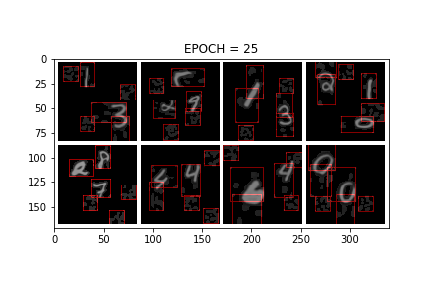

In [46]:
show_frame(25)

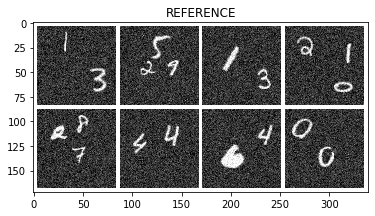

In [37]:
show_batch(reference_imgs[:8],nrow=4,npadding=4,title="REFERENCE")


# Comparison of ELBO, GRAPH_ELBO, ENUM_ELBO

In [48]:
display.HTML("<img src='./COMPARISON/my_movie_traceENUM_elbo.gif'></img>")

In [49]:
display.HTML("<img src='./COMPARISON/my_movie_traceGRAPH_elbo.gif'></img>")

In [50]:
display.HTML("<img src='./COMPARISON/my_movie_trace_elbo.gif'></img>")